# Make the figures for the paper

This notebook generates the figures used in the paper. **No results are calculated here**. We'll only load the results from files produced by other notebook.

## Package imports

In [1]:
# Insert the plots into the notebook
%matplotlib inline

In [2]:
from __future__ import division
import cPickle as pickle
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import seaborn  # Makes the default style of the plots nicer

/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from datasets import fetch_crust1, load_icgem_gdf, down_sample, fetch_assumpcao_moho_points
from mohoinv import predict_seismic

Set the global plot style parameters.

In [4]:
seaborn.set_context('paper')
config = dict(fontsize=6)
plt.rcParams['font.size'] = config['fontsize']
plt.rcParams['axes.labelsize'] = config['fontsize']
plt.rcParams['xtick.labelsize'] = config['fontsize']
plt.rcParams['ytick.labelsize'] = config['fontsize']
plt.rcParams['legend.fontsize'] = config['fontsize']
plt.rcParams['xtick.major.pad'] = 3
plt.rcParams['ytick.major.pad'] = 3

The function below takes the data and sets the colorbar limits so that zero falls in the middle of the color range.

In [5]:
def data_minmax(data, shift=0):
    ranges = np.abs([data.min(), data.max()]).max()
    return dict(vmin=-ranges + shift, vmax=ranges + shift)

## Simple synthetic

This section generates figures for the simple synthetic data application.

Load the model, synthetic data, and the results dictionary.

In [6]:
with open('../model/synthetic-simple.pickle') as f:
    model = pickle.load(f)

In [7]:
with open('../data/synthetic-data-simple.txt') as f:
    for i in range(2):
        f.readline()
    line = f.readline()
    shape = map(int, line.split()[1:])
    lat, lon, height, data = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 4])

In [8]:
with zipfile.ZipFile('results/synthetic-simple.zip') as f:
    results = pickle.load(f.open('synthetic-simple.pickle'))

In [9]:
results.keys()

['best_index',
 'solution',
 'solutions',
 'scores',
 'regul_params',
 'config',
 'metadata']

In [10]:
print(results['metadata'])

Generated by sinthetic-simple.ipynb on 20 February 2016 22:06:03 UTC


Make the map projection for these plots.

In [11]:
bm = Basemap(projection='cyl', 
             llcrnrlon=model.area[2], urcrnrlon=model.area[3], 
             llcrnrlat=model.area[0], urcrnrlat=model.area[1],
             resolution='c')

Plot the data and model in a figure.

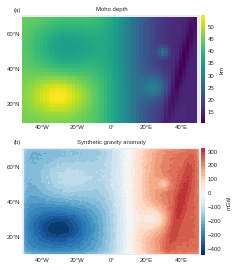

In [12]:
fig = plt.figure(figsize=(3.33, 3.7))

grid = AxesGrid(fig, [0.08, 0.05, 0.8, 0.9], 
                nrows_ncols=(2, 1), axes_pad=0.35,
                cbar_location="right", cbar_mode="each",
                cbar_size="2%", cbar_pad=0.01)

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(-0.05, 1.04, '(a)', transform=ax.transAxes, **config)
ax.set_title('Moho depth', **config)
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))
tmp = bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='viridis')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=10))
cbax.set_ylabel('km')
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels([20, 40, 60], labels=[1, 0, 0, 0], linewidth=0, **config)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(-0.05, 1.04, '(b)', transform=ax.transAxes, **config)
ax.set_title('Synthetic gravity anomaly', **config)
x, y = bm(lon.reshape(shape), lat.reshape(shape))
tmp = bm.contourf(x, y, data.reshape(shape), 30, cmap='RdBu_r', **data_minmax(data))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
cbax.set_ylabel('mGal')
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels([20, 40, 60], labels=[1, 0, 0, 0], linewidth=0, **config)

plt.savefig('../manuscript/figures/synthetic-simple-data.eps')

Extract some of the data from the results dictionary.

In [12]:
moho = results['solution'].estimate_    
solution = results['solution'][0]
residuals = solution.residuals()
regul_params = results['regul_params']
scores = results['scores']
best = results['best_index']
solver = results['solution']
diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)

In [13]:
diff.max(),  diff.min()

(2.1910477689482541, -2.1277272133152509)

In [14]:
regul_params[best]

0.00046415888336127773

Make a figure of the inversion results.

/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


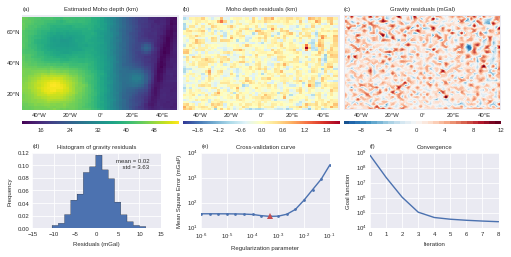

In [16]:
fig = plt.figure(figsize=(7, 3.5))

# The first part will be 3 maps
grid = AxesGrid(fig, [0.04, 0.33, 0.95, 0.8], 
                nrows_ncols=(1, 3), axes_pad=0.05,
                cbar_location="bottom", cbar_mode="each",
                cbar_size=0.04, cbar_pad=0.15)

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.05, '(a)', transform=ax.transAxes, **config)
ax.set_title('Estimated Moho depth (km)', **config)
x, y = bm(moho.lons, moho.lats)
tmp = bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='viridis')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels([20, 40, 60], labels=[1, 0, 0, 0], linewidth=0, **config)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.05, '(b)', transform=ax.transAxes, **config)
ax.set_title('Moho depth residuals (km)', **config)
tmp = bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', **data_minmax(diff))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.05, '(c)', transform=ax.transAxes, **config)
ax.set_title('Gravity residuals (mGal)', **config)
x, y = bm(solution.lon, solution.lat)
tmp = bm.contourf(x, y, residuals, 30, tri=True, cmap='RdBu_r', **data_minmax(residuals))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)

# Now make the axes to plot the 3 graphs on the bottom
height, bottom = 0.3, 0.1
left,  width, pad = 0.06, 0.255, 0.08
grid2 = [plt.axes([left, bottom, width, height]),
         plt.axes([left + width + pad, bottom, width, height]),
         plt.axes([left + 2*(width + pad), bottom, width, height])]

ax = grid2[0]
ax.text(0, 1.07, '(d)', transform=ax.transAxes, **config)
ax.set_title('Histogram of gravity residuals', **config)
text = "mean = {:.2f}\n    std = {:.2f}".format(
    residuals.mean(), residuals.std())
ax.text(0.65, 0.8, text, transform=ax.transAxes, **config)
ax.hist(residuals, bins=15, normed=True, histtype='stepfilled')
ax.set_xlabel('Residuals (mGal)')
ax.set_ylabel('Frequency')

ax = grid2[1]
ax.text(0, 1.07, '(e)', transform=ax.transAxes, **config)
ax.set_title('Cross-validation curve', **config)
ax.plot(regul_params, scores, '.-')
ax.plot(regul_params[best], scores[best], '^', 
         color=seaborn.color_palette()[2], 
         label='Minimum')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel(u'Mean Square Error (mGal²)')

ax = grid2[2]
ax.text(0, 1.07, '(f)', transform=ax.transAxes, **config)
ax.set_title("Convergence", **config)
ax.plot(range(solver.stats_['iterations'] + 1), solver.stats_['objective'])
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Goal function')

plt.savefig('../manuscript/figures/synthetic-simple-results.eps')

## CRUST1.0 synthetic

In [17]:
with open('../model/synthetic-crust1.pickle') as f:
    model = pickle.load(f)

In [18]:
with open('../data/synthetic-data-crust1.txt') as f:
    for i in range(2):
        f.readline()
    line = f.readline()
    shape = map(int, line.split()[1:])
    lat, lon, height, data = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 4])

In [19]:
latp, lonp, depthp = np.loadtxt('../data/crust1-point-depths.txt', unpack=True)

In [20]:
with zipfile.ZipFile('results/synthetic-crust1.zip') as f:
    results = pickle.load(f.open('synthetic-crust1.pickle'))

In [21]:
results.keys()

['models_refdens',
 'densities',
 'reference_levels',
 'solution_regul',
 'scores_regul',
 'models_regul',
 'solution',
 'best_dens',
 'scores_refdens',
 'best_regul',
 'regul_params',
 'config',
 'best_ref',
 'metadata']

In [22]:
print(results['metadata'])

Generated by sinthetic-crust1.ipynb on 05 February 2016 21:48:27 UTC


Make the map projection for these plots.

In [23]:
bm = Basemap(projection='cyl', 
             llcrnrlon=model.area[2], urcrnrlon=model.area[3], 
             llcrnrlat=model.area[0], urcrnrlat=model.area[1],
             resolution='l')

Plot the data and model in a figure.

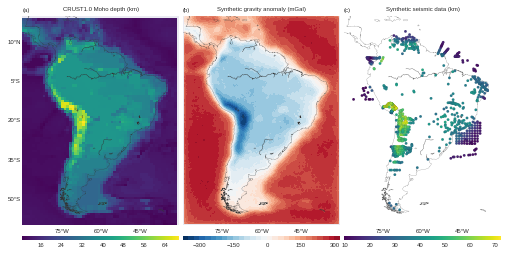

In [22]:
fig = plt.figure(figsize=(7, 3.5))

grid = AxesGrid(fig, [0.04, 0.01, 0.95, 0.98], 
                nrows_ncols=(1, 3), axes_pad=0.05,
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="5%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.set_title('CRUST1.0 Moho depth (km)', **config)
ax.text(0, 1.02, '(a)', transform=ax.transAxes, **config)
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))
tmp = bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='viridis')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.set_title('Synthetic gravity anomaly (mGal)', **config)
ax.text(0, 1.02, '(b)', transform=ax.transAxes, **config)
x, y = bm(lon.reshape(shape), lat.reshape(shape))
tmp = bm.contourf(x, y, data.reshape(shape), 30, cmap='RdBu_r', **data_minmax(data))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.set_title('Synthetic seismic data (km)', **config)
ax.set_axis_bgcolor('white')
ax.text(0, 1.02, '(c)', transform=ax.transAxes, **config)
xp, yp = bm(lonp, latp)
tmp = bm.scatter(xp, yp, c=depthp*0.001, s=7, cmap='viridis',
                 linewidths=0.05)
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#666666", linewidth=0.2, zorder=0)

plt.savefig('../manuscript/figures/synthetic-crust1-data.eps')

Extract some things from the results dictionary.

In [24]:
moho = results['solution'].estimate_    
solution = results['solution'][0]
residuals = solution.residuals()
regul_params = results['regul_params']
scores_regul = results['scores_regul']
best_reg = results['best_regul']
reference_levels = results['reference_levels']
densities = results['densities']
scores_refdens = results['scores_refdens']
best_ref = results['best_ref']
best_dens = results['best_dens']
diff_seismic = -0.001*(-depthp - predict_seismic(moho, latp, lonp))
diff_model = -0.001*(model.relief - moho.relief).reshape(moho.shape)

In [25]:
diff_model.max(),  diff_model.min()

(9.8358547811799735, -8.2322778445448286)

In [26]:
diff_seismic.max(),  diff_seismic.min()

(9.4374315564211066, -7.5973400319479261)

In [27]:
regul_params[best_reg]

0.0001

Make a figure of the inversion results.

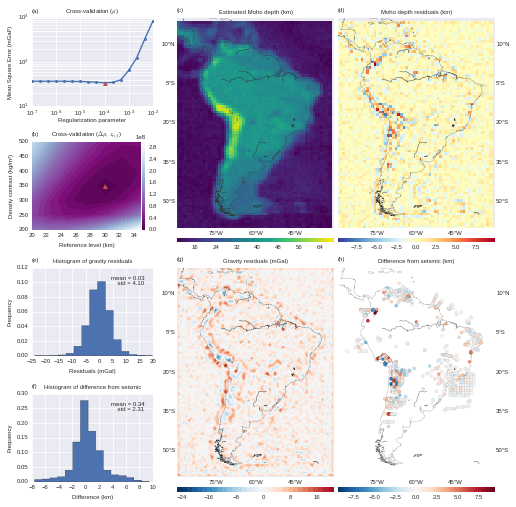

In [30]:
fig = plt.figure(figsize=(7, 7))

# The four graphs
height, pad = 0.25, 0.075
left, width = 0.052, 0.24
grid2 = [plt.axes([left, 0.545 + height, width, height - pad]),
         plt.axes([left, 0.55, width - 0.015, height - pad]),
         plt.axes([left, 0.05 + height, width, height - pad]),         
         plt.axes([left, 0.05, width, height - pad])]


ax = grid2[0]
ax.text(0, 1.06, '(a)', transform=ax.transAxes, **config)
ax.set_title(r'Cross-validation ($\mu$)', **config)
ax.plot(regul_params, scores_regul, marker='o', markersize=3)
ax.plot(regul_params[best_reg], scores_regul[best_reg], '^', markersize=5, 
        color=seaborn.color_palette()[2], 
        label='Minimum')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Regularization parameter', labelpad=0.5)
ax.set_ylabel(u'Mean Square Error (mGal²)')
ax.yaxis.grid(True, which='minor')

ax = grid2[1]
ax.text(0, 1.07, '(b)', transform=ax.transAxes, **config)
ax.set_title(r'Cross-validation ($\Delta\rho$, $z_{ref}$)', **config)
tmp = ax.contourf(-0.001*reference_levels, densities, scores_refdens, 30, cmap='BuPu_r')
divider = make_axes_locatable(ax)
cbax = divider.append_axes("right", size=0.05, pad=0.01)
plt.colorbar(tmp, cax=cbax)
ax.plot(-0.001*reference_levels[best_ref], densities[best_dens], '^', markersize=5, 
        color=seaborn.color_palette()[2], label='Minimum')
ax.set_xlabel('Reference level (km)')
ax.set_ylabel(u'Density contrast (kg/m³)')

ax = grid2[2]
ax.text(0, 1.06, '(e)', transform=ax.transAxes, **config)
ax.set_aspect('auto')
ax.set_title('Histogram of gravity residuals', **config)
text = "mean = {:.2f}\n    std = {:.2f}".format(
    residuals.mean(), residuals.std())
ax.text(0.65, 0.8, text, transform=ax.transAxes, **config)
ax.hist(residuals, bins=15, normed=True, histtype='stepfilled')
ax.set_xlabel('Residuals (mGal)')
ax.set_ylabel('Frequency')

ax = grid2[3]
ax.text(0, 1.06, '(f)', transform=ax.transAxes, **config)
ax.set_title('Histogram of difference from seismic', **config)
text = "mean = {:.2f}\n    std = {:.2f}".format(
    diff_seismic.mean(), diff_seismic.std())
ax.text(0.65, 0.8, text, transform=ax.transAxes, **config)
ax.hist(diff_seismic, bins=15, normed=True, histtype='stepfilled')
ax.set_xlabel('Difference (km)')
ax.set_ylabel('Frequency')


# The four maps
grid = AxesGrid(fig, [0.34, 0.01, 0.63, 0.98], 
                nrows_ncols=(2, 2), axes_pad=(0.05, 0.35),
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="5%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(c)', transform=ax.transAxes, **config)
ax.set_title('Estimated Moho depth (km)', **config)
x, y = bm(moho.lons, moho.lats)
vmin, vmax = [func(-0.001*model.relief) for func in [np.min, np.max]]
tmp = bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='viridis',
                    vmin=vmin, vmax=vmax)
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(d)', transform=ax.transAxes, **config)
ax.set_title('Moho depth residuals (km)', **config)
x, y = bm(moho.lons, moho.lats)
tmp = bm.pcolormesh(x, y, diff_model, cmap='RdYlBu_r', **data_minmax(diff_model))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(g)', transform=ax.transAxes, **config)
ax.set_title('Gravity residuals (mGal)', **config)
x, y = bm(solution.lon, solution.lat)
tmp = bm.contourf(x, y, residuals, 30, tri=True, cmap='RdBu_r', **data_minmax(residuals))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 3
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(h)', transform=ax.transAxes, **config)
ax.set_axis_bgcolor('white')
ax.set_title('Difference from seismic (km)', **config)
xp, yp = bm(lonp, latp)
tmp = bm.scatter(xp, yp, c=diff_seismic, s=10, cmap='RdBu_r',
                 linewidths=0.05, **data_minmax(diff_seismic))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#666666", linewidth=0.2, zorder=0)


plt.savefig('../manuscript/figures/synthetic-crust1-results.eps')

## Data for the South America application

Load the processed gravity data.

In [31]:
with open('../data/processed-goco5s-data-sam-h50km.txt') as f:
    for i in range(2):
        f.readline()
    shape = tuple(int(i) for i in f.readline().split()[1:])
    data = np.loadtxt(f, unpack=True)
    lat, lon, height, topo, grav, disturbance, topo_effect, bouguer = data[:8]
    upper_sed, middle_sed, lower_sed, total_sed, sedfree_bouguer = data[8:]
    area = (lat.min(), lat.max(), lon.min(), lon.max())

Load the sediment model from CRUST1.0.

In [32]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut(area)

Load the seismic point estimates of Moho depth from [Assumpção et al. (2013)](http://dx.doi.org/10.1016%2Fj.tecto.2012.11.014).

In [33]:
seismic_data = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz', 
                                           todepth=True, return_height=False)
latp, lonp, seismic_moho = seismic_data[:-1]
lonp += 360

Setup a [basemap](http://matplotlib.org/basemap/index.html) to plot the data with an appropriate projection.

In [34]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

Convert the data, CRUST1.0, and seismic data coordinates to the projection.

In [35]:
x, y = bm(lon.reshape(shape), lat.reshape(shape))

In [36]:
xc, yc = bm(crust1.lon + 360, crust1.lat)

In [37]:
xp, yp = bm(lonp, latp)

Plot maps of the stages in the data correction, topography, and the sediment model used.

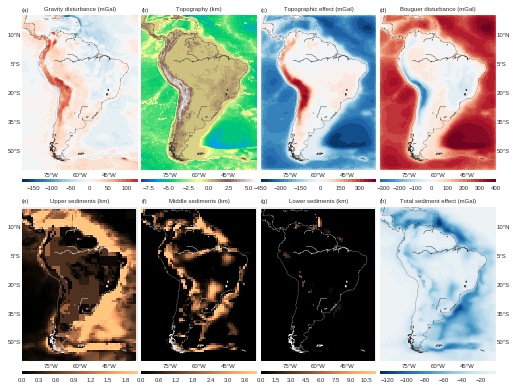

In [14]:
fig = plt.figure(figsize=(7, 5.4))

grid = AxesGrid(fig, [0.03, 0.01, 0.94, 0.98], 
                nrows_ncols=(2, 4), axes_pad=(0.05, 0.35),
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="6%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(a)', transform=ax.transAxes, **config)
ax.set_title('Gravity disturbance (mGal)', **config)
tmp = bm.contourf(x, y, disturbance.reshape(shape), 30, cmap='RdBu_r', 
                  **data_minmax(disturbance))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(b)', transform=ax.transAxes, **config)
ax.set_title('Topography (km)', **config)
tmp = bm.contourf(x, y, 0.001*topo.reshape(shape), 40, cmap='terrain')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=7))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(c)', transform=ax.transAxes, **config)
ax.set_title('Topographic effect (mGal)', **config)
tmp = bm.contourf(x, y, topo_effect.reshape(shape), 30, cmap='RdBu_r', 
                  **data_minmax(topo_effect))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 3
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(d)', transform=ax.transAxes, **config)
ax.set_title('Bouguer disturbance (mGal)', **config)
tmp = bm.contourf(x, y, bouguer.reshape(shape), 30, cmap='RdBu_r', 
                  **data_minmax(bouguer))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 4
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(e)', transform=ax.transAxes, **config)
ax.set_title('Upper sediments (km)', **config)
tmp = bm.pcolormesh(xc, yc, 0.001*crust1.upper_sediments.thickness, cmap='copper')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#eeeeee", linewidth=0.2)

i = 5
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(f)', transform=ax.transAxes, **config)
ax.set_title('Middle sediments (km)', **config)
tmp = bm.pcolormesh(xc, yc, 0.001*crust1.middle_sediments.thickness, cmap='copper')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#eeeeee", linewidth=0.2)

i = 6
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(g)', transform=ax.transAxes, **config)
ax.set_title('Lower sediments (km)', **config)
tmp = bm.pcolormesh(xc, yc, 0.001*crust1.lower_sediments.thickness, cmap='copper')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#eeeeee", linewidth=0.2)

i = 7
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(h)', transform=ax.transAxes, **config)
ax.set_title('Total sediment effect (mGal)', **config)
tmp = bm.contourf(x, y, total_sed.reshape(shape), 30, cmap='RdBu_r', 
                  **data_minmax(total_sed))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

plt.savefig('../manuscript/figures/south-america-corrections.eps')

Plot the input data for the inversion: the final sediment-free Bouguer disturbance and the seismic data.

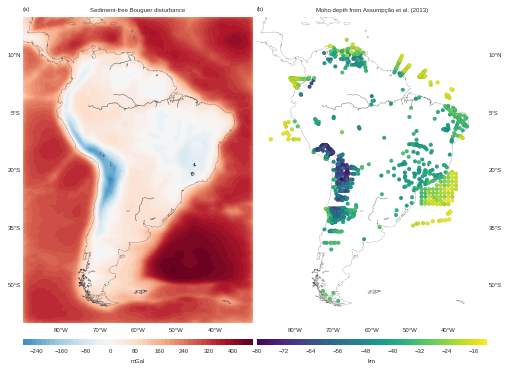

In [39]:
fig = plt.figure(figsize=(7, 5))

grid = AxesGrid(fig, [0.04, 0.02, 0.92, 0.98], 
                nrows_ncols=(1, 2), axes_pad=(0.05),
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="5%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.02, '(a)', transform=ax.transAxes, **config)
ax.set_title('Sediment-free Bouguer disturbance', **config)
tmp = bm.contourf(x, y, sedfree_bouguer.reshape(shape), 50, cmap='RdBu_r',
                  **data_minmax(sedfree_bouguer))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=10))
cbax.set_xlabel('mGal')
bm.drawmeridians([-80, -70, -60, -50, -40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.02, '(b)', transform=ax.transAxes, **config)
ax.set_title(u'Moho depth from Assumpção et al. (2013)', **config)
ax.set_axis_bgcolor('white')
tmp = bm.scatter(xp, yp, c=seismic_moho*0.001, s=15, cmap='viridis',
                 linewidths=0.05)
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=10))
cbax.set_xlabel('km')
bm.drawmeridians([-80, -70, -60, -50, -40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#666666", linewidth=0.2, zorder=0)

plt.savefig('../manuscript/figures/south-america-data.eps')

## South American Moho

First, join the two halfs of the zipped results into a single file using some bash commands.

In [13]:
%%bash
cd results
cat south-america-moho.zip.part* > south-america-moho.zip
cd ..

Load the pickled results dictionary from the combined zip file.

In [14]:
with zipfile.ZipFile('results/south-america-moho.zip') as f:
    results = pickle.load(f.open('south-america-moho.pickle'))

We'll use the same basemap from the previous figures.

In [15]:
solution = results['solution']
moho = solution.estimate_

In [16]:
xm, ym = bm(moho.lon, moho.lat)

In [17]:
diff_seismic = -0.001*(seismic_moho - predict_seismic(moho, latp, lonp))
print(diff_seismic.min(), diff_seismic.max())
print(diff_seismic.mean(), diff_seismic.std())

(-22.788392791744613, 22.78909884206325)
(1.1758194640786224, 6.8359476475916532)


In [18]:
residuals = solution[0].residuals()
xr, yr = bm(solution[0].lon, solution[0].lat)
print(residuals.min(), residuals.max())

(-28.362343001382925, 22.995475661988333)


Plot the estimated Moho depth, residuals, and differences with the seismic constraints.

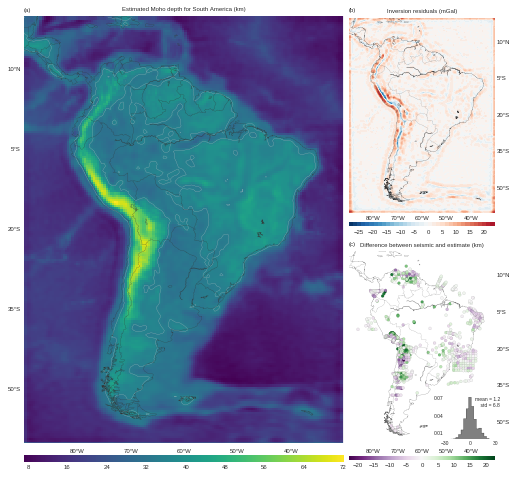

In [39]:
fig = plt.figure(figsize=(7, 6.55))

grid_moho = AxesGrid(fig, [0.035, 0.01, 0.635, 0.98], 
                nrows_ncols=(1, 1),
                cbar_location="bottom", cbar_mode="each",
                cbar_size="1.5%", cbar_pad="3%")

ax, bm.ax, cbax = grid_moho[0], grid_moho[0], grid_moho.cbar_axes[0]
ax.text(0, 1.01, '(a)', transform=ax.transAxes, **config)
ax.set_title(u'Estimated Moho depth for South America (km)', **config)
tmp = bm.pcolormesh(xm, ym, -0.001*moho.relief.reshape(moho.shape), 
                    cmap='viridis')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=10))
cs = bm.contour(xm, ym, -0.001*moho.relief.reshape(moho.shape), 
                [35], colors='#cccccc', linewidths=0.2)
#cs.clabel(fmt='%g', fontsize=config['fontsize'] - 1)
bm.drawmeridians([-80, -70, -60, -50, -40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)
bm.drawcountries(color="#333333", linewidth=0.2)

grid = AxesGrid(fig, [0.68, 0.01, 0.29, 0.98], 
                nrows_ncols=(2, 1), axes_pad=0.35,
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="5%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(b)', transform=ax.transAxes, **config)
ax.set_title('Inversion residuals (mGal)', **config)
tmp = bm.contourf(xr, yr, residuals, 50, tri=True, cmap='RdBu_r', **data_minmax(residuals))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=12))
bm.drawmeridians([-80, -70, -60, -50, -40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)
bm.drawcountries(color="#333333", linewidth=0.1)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(c)', transform=ax.transAxes, **config)
ax.set_axis_bgcolor('white')
ax.set_title(u'Difference between seismic and estimate (km)', **config)
tmp = bm.scatter(xp, yp, c=diff_seismic, s=9, cmap='PRGn',
                 linewidths=0.05, **data_minmax(diff_seismic))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=10))
bm.drawmeridians([-80, -70, -60, -50, -40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#666666", linewidth=0.2, zorder=0)
bm.drawcountries(color="#333333", linewidth=0.1)

ax = plt.axes([0.87, 0.075, 0.1, 0.10])
ax.set_axis_bgcolor('white')
ax.grid(False)
text = "mean = {:.1f}\n    std = {:.1f}".format(
    diff_seismic.mean(), diff_seismic.std())
ax.text(0.6, 0.7, text, transform=ax.transAxes, 
        fontsize=config['fontsize'] - 1)
ax.hist(diff_seismic, bins=15, normed=True, histtype='stepfilled', color='grey')
ax.set_yticks(ax.get_yticks()[1:-1:3])
ax.set_xticks(ax.get_xticks()[::3])
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(config['fontsize'] - 1)
    tick.set_pad(1)

plt.savefig('../manuscript/figures/south-america-moho.eps')

Plot the cross-validation results.

In [43]:
regul_params = results['regul_params']
scores_regul = results['scores_regul']
best_reg = results['best_regul']
reference_levels = results['reference_levels']
densities = results['densities']
scores_refdens = results['scores_refdens']
best_ref = results['best_ref']
best_dens = results['best_dens']

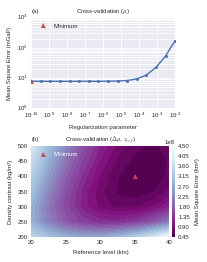

In [44]:
fig = plt.figure(figsize=(3.33, 3.5))

left, width, height = 0.2, 0.6, 0.36
grid = [plt.axes([left, 0.59, width, height]),
        plt.axes([left, 0.08, width, height])]

ax = grid[0]
ax.text(0, 1.06, '(a)', transform=ax.transAxes, **config)
ax.set_title(r'Cross-validation ($\mu$)', **config)
ax.plot(regul_params, scores_regul, marker='o', markersize=3)
ax.plot(regul_params[best_reg], scores_regul[best_reg], '^', markersize=5, 
        color=seaborn.color_palette()[2], 
        label='Minimum')
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel(u'Mean Square Error (mGal²)')
ax.yaxis.grid(True, which='minor')

ax = grid[1]
ax.text(0, 1.06, '(b)', transform=ax.transAxes, **config)
ax.set_title(r'Cross-validation ($\Delta\rho$, $z_{ref}$)', **config)
tmp = ax.contourf(-0.001*reference_levels, densities, scores_refdens, 30, cmap='BuPu_r')
divider = make_axes_locatable(ax)
cbax = divider.append_axes("right", size=0.05, pad=0.03)
plt.colorbar(tmp, cax=cbax)
cbax.set_ylabel(u'Mean Square Error (km²)')
ax.plot(-0.001*reference_levels[best_ref], densities[best_dens], '^', markersize=5, 
        color=seaborn.color_palette()[2], label='Minimum')
l = ax.legend(loc='upper left')
for txt in l.get_texts():
    txt.set_color('#ffffff')
ax.set_xlabel('Reference level (km)')
ax.set_ylabel(u'Density contrast (kg/m³)')

plt.savefig('../manuscript/figures/south-america-cv.eps')

[]()